# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# set thresholds

In [2]:
thresholds_list = [ 0.5, 1.3, 2.7, 5, 10, 15, 25]

# Load in stations

## GMET

In [3]:
# Load GMET station data (CSV format with columns:'precipitation')
gmet_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\GMET\GMet_AWSdata\GMet_AWSdata'

station_data_list_GMET = []
station_name_list_files = []
for station in os.listdir(gmet_root_dir):
    if station.endswith('.csv'):
        station_file = os.path.join(gmet_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_data_list_GMET.append(station_data)
        station_name_list_files.append(station.split('.')[0])
        #display(station_data)

stations_meta_data_GMET = station_data_list_GMET.pop(7)
station_name_list = stations_meta_data_GMET['STN'].tolist()

station_data_gmet_dict = dict(zip(station_name_list, station_data_list_GMET))

for station_name in station_data_gmet_dict:
    # Convert 'timestamp' column to datetime format
    station_data_gmet_dict[station_name]['Timestamp'] = pd.to_datetime(
        station_data_gmet_dict[station_name]['Date'].astype(str) + ' ' + 
        station_data_gmet_dict[station_name]['Time'].astype(str),
        format='%m/%d/%Y %I:%M:%S %p'
    )
    # Set Timestamp as the index
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].set_index('Timestamp')
    # Drop the original Date and Time columns
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].drop(['Date', 'Time'], axis=1)

    # Ensure the column is numeric
    for col in station_data_gmet_dict[station_name].columns:
        station_data_gmet_dict[station_name][col] = pd.to_numeric(station_data_gmet_dict[station_name][col], errors='coerce')

    # Accumulate over 30 minutes
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)

## Tahmo

In [4]:
tahmo_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\TAHMO\TAHMO_export_6704eaa37e81da18c0b7e245'

station_name_list = []
station_data_list_TAHMO = []
for station in os.listdir(tahmo_root_dir): 
    if station.endswith('.csv'):
        station_file = os.path.join(tahmo_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_name_list.append(station.split('.')[0])
        station_data_list_TAHMO.append(station_data)

sensors_meta_data_tahmo = station_data_list_TAHMO.pop(0)
stations_meta_data_tahmo = station_data_list_TAHMO.pop(0)
sensors_meta_data_tahmo_name = station_name_list.pop(0)
stations_meta_data_tahmo_name = station_name_list.pop(0)


station_data_tahmo_dict = dict(zip(station_name_list, station_data_list_TAHMO))

#Assuming df is the DataFrame containing the data
for station_name in station_data_tahmo_dict:
    if station_data_tahmo_dict[station_name].shape[1] == 3:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 2])

        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2]], axis = 1)

        # # Result
        # display(station_data_tahmo_dict[station_name].head())

    elif station_data_tahmo_dict[station_name].shape[1] == 4:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 1]).combine_first(station_data_tahmo_dict[station_name].iloc[:, 3])
        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2, 3]], axis = 1)


    if 'timestamp' in station_data_tahmo_dict[station_name].columns:
        # Set Timestamp as the index
        station_data_tahmo_dict[station_name]['timestamp'] = pd.to_datetime(station_data_tahmo_dict[station_name]['timestamp'])
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].set_index('timestamp')

    # Accumulate over 30 minutes
    station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)


# Metrics calculation function

In [5]:
def dataframe_metrics_gmet(df_grid, station_data_gmet_dict, output_name):

    # A dictionary to store the results for each station
    results_dict = {}
    eps = 1e-6
    for station_name in station_data_gmet_dict:
        # Merge the dataframes
        df = pd.concat([df_grid[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)
        
        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')

        
        
        # Drop rows with NaN values after conversion
        df = df.dropna()

        #df = df.resample('D').sum()
    
        # Initialize a dictionary to store results for each threshold for this station
        station_results = []
    
        for T in thresholds_list:
            # Calculate binary predictions and targets
            df['p'] = (df[station_name] >= T).astype(float)
            df['t'] = (df['Precipitation (mm)'] >= T).astype(float)
            
            # Calculate hits, misses, and false alarms
            hits = ((df['p'] == 1) & (df['t'] == 1)).sum()
            misses = ((df['p'] == 0) & (df['t'] == 1)).sum()
            false_alarms = ((df['p'] == 1) & (df['t'] == 0)).sum()
            
            # Append results for the current threshold
            station_results.append({'Threshold': T, 'Hits': hits, 'Misses': misses, 'False Alarms': false_alarms})
        
        # Store results for this station
        results_dict[station_name] = pd.DataFrame(station_results)
    
    # Combine results for all stations into one DataFrame
    final_results = pd.concat(results_dict, names=['Station', 'Index'])
    
    final_results['POD'] = final_results['Hits'] / (final_results['Hits'] + final_results['Misses'] + eps)
    final_results['CSI'] = final_results['Hits'] / (final_results['Hits'] + final_results['False Alarms'] + final_results['Misses'] + eps) 
    final_results['FAR'] = final_results['False Alarms'] / (final_results['False Alarms'] + final_results['Hits'] + eps)
    final_results['SUCR'] = final_results['Hits'] / (final_results['Hits'] + final_results['False Alarms'] + eps) 
    final_results['Bias'] = (final_results['Hits']  + final_results['False Alarms']) / (final_results['Misses'] + final_results['Hits'] + eps) 
    
    # Save results to a file
    final_results.to_csv(f'{output_name}.csv')
    
    print(f"Calculation complete. Results saved to {output_name}.csv")
    return final_results

In [6]:
def dataframe_metrics_tahmo(df_grid, station_data_tahmo_dict, output_name):

    # A dictionary to store the results for each station
    results_dict = {}
    eps = 1e-6
    for station_name in station_data_tahmo_dict:
        # Merge the dataframes
        df = pd.concat([df_grid[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)
        
        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')

        
        
        # Drop rows with NaN values after conversion
        df = df.dropna()

        #df = df.resample('D').sum()
    
        # Initialize a dictionary to store results for each threshold for this station
        station_results = []
    
        for T in thresholds_list:
            # Calculate binary predictions and targets
            df['p'] = (df[station_name] >= T).astype(float)
            df['t'] = (df['precipitation (mm)'] >= T).astype(float)
            
            # Calculate hits, misses, and false alarms
            hits = ((df['p'] == 1) & (df['t'] == 1)).sum()
            misses = ((df['p'] == 0) & (df['t'] == 1)).sum()
            false_alarms = ((df['p'] == 1) & (df['t'] == 0)).sum()
            
            # Append results for the current threshold
            station_results.append({'Threshold': T, 'Hits': hits, 'Misses': misses, 'False Alarms': false_alarms})
        
        # Store results for this station
        results_dict[station_name] = pd.DataFrame(station_results)
    
    # Combine results for all stations into one DataFrame
    final_results = pd.concat(results_dict, names=['Station', 'Index'])
    
    final_results['POD'] = final_results['Hits'] / (final_results['Hits'] + final_results['Misses'] + eps)
    final_results['CSI'] = final_results['Hits'] / (final_results['Hits'] + final_results['False Alarms'] + final_results['Misses'] + eps) 
    final_results['FAR'] = final_results['False Alarms'] / (final_results['False Alarms'] + final_results['Hits'] + eps)
    final_results['SUCR'] = final_results['Hits'] / (final_results['Hits'] + final_results['False Alarms'] + eps) 
    final_results['Bias'] = (final_results['Hits']  + final_results['False Alarms']) / (final_results['Misses'] + final_results['Hits'] + eps) 
    
    # Save results to a file
    final_results.to_csv(f'{output_name}.csv')
    
    print(f"Calculation complete. Results saved to {output_name}.csv")
    return final_results

# Calculate metrics

In [7]:
df_earth_gmet_stations = pd.read_csv('df_output_MSE_gmet_2022.csv', index_col = 0, parse_dates = True)
df_earth_balanced_gmet_stations = pd.read_csv('df_output_balanced_gmet_2022.csv', index_col = 0, parse_dates = True)
df_target_gmet_stations = pd.read_csv('df_imerg_final_gmet.csv', index_col = 0, parse_dates = True)
df_target_gmet_stations = df_target_gmet_stations.loc['2022']
df_early_gmet_stations = pd.read_csv('df_imerg_early_gmet.csv', index_col = 0, parse_dates = True)
df_early_gmet_stations = df_early_gmet_stations.loc['2022']

df_earth_tahmo_stations = pd.read_csv('df_output_MSE_tahmo_2022.csv', index_col = 0, parse_dates = True)
df_earth_balanced_tahmo_stations = pd.read_csv('df_output_balanced_tahmo_2022.csv', index_col = 0, parse_dates = True)
df_target_tahmo_stations = pd.read_csv('df_imerg_final_tahmo.csv', index_col = 0, parse_dates = True)
df_target_tahmo_stations = df_target_tahmo_stations.loc['2022']
df_early_tahmo_stations = pd.read_csv('df_imerg_early_tahmo.csv', index_col = 0, parse_dates = True)
df_early_tahmo_stations = df_early_tahmo_stations.loc['2022']

# Set excluded stations

In [8]:
drop_data_gmet = ['Ada_Foah', 'Tarkwa', 'Abetifi', 'Sefwi_Bekwai', 'Loagri', 'Kalbeo', 'Jirapa']
drop_data_tahmo = ['TA00117', 'TA00302', 'TA00007', 'TA00010', 'TA00266', 'TA00259', 'TA00690', 'TA00254', 'TA00647']

# Calculate metrics

In [9]:
df_earth_gmet = dataframe_metrics_gmet(df_earth_gmet_stations, station_data_gmet_dict, 'df_output_MSE_loss_metrics_gmet')
df_earth_balanced_gmet = dataframe_metrics_gmet(df_earth_balanced_gmet_stations, station_data_gmet_dict, 'df_output_loss_balanced_metrics_gmet')
df_target_gmet = dataframe_metrics_gmet(df_target_gmet_stations, station_data_gmet_dict, 'df_target_MSE_loss_metrics_gmet')
df_early_gmet = dataframe_metrics_gmet(df_early_gmet_stations, station_data_gmet_dict, 'df_imerg_early_metrics_gmet')

df_earth_tahmo = dataframe_metrics_tahmo(df_earth_tahmo_stations, station_data_tahmo_dict, 'df_output_MSE_loss_metrics_tahmo')
df_earth_balanced_tahmo = dataframe_metrics_tahmo(df_earth_balanced_tahmo_stations, station_data_tahmo_dict, 'df_output_loss_balanced_metrics_tahmo')
df_target_tahmo = dataframe_metrics_tahmo(df_target_tahmo_stations, station_data_tahmo_dict, 'df_target_MSE_loss_metrics_tahmo')
df_early_tahmo = dataframe_metrics_tahmo(df_early_tahmo_stations, station_data_tahmo_dict, 'df_imerg_early_metrics_tahmo')

Calculation complete. Results saved to df_output_MSE_loss_metrics_gmet.csv
Calculation complete. Results saved to df_output_loss_balanced_metrics_gmet.csv
Calculation complete. Results saved to df_target_MSE_loss_metrics_gmet.csv
Calculation complete. Results saved to df_imerg_early_metrics_gmet.csv
Calculation complete. Results saved to df_output_MSE_loss_metrics_tahmo.csv
Calculation complete. Results saved to df_output_loss_balanced_metrics_tahmo.csv
Calculation complete. Results saved to df_target_MSE_loss_metrics_tahmo.csv
Calculation complete. Results saved to df_imerg_early_metrics_tahmo.csv


In [10]:
df_earth_tahmo = pd.read_csv('df_output_MSE_loss_metrics_tahmo.csv')
df_earth_tahmo['model'] = 'earthformer_MSE_loss'

df_earth_balanced_tahmo = pd.read_csv('df_output_loss_balanced_metrics_tahmo.csv')
df_earth_balanced_tahmo['model'] = 'earthformer_balanced_loss'

df_target_tahmo = pd.read_csv('df_target_MSE_loss_metrics_tahmo.csv')
df_target_tahmo['model'] = 'IMERG-Final'

df_early_tahmo = pd.read_csv('df_imerg_early_metrics_tahmo.csv')
df_early_tahmo['model'] = 'IMERG-Early'

df_combined_tahmo = pd.concat([df_earth_tahmo, df_earth_balanced_tahmo, df_early_tahmo, df_target_tahmo])

# Drop rows where Station is TA00005
for station in drop_data_tahmo:
    df_combined_tahmo = df_combined_tahmo[df_combined_tahmo['Station'] != station]

In [11]:
df_earth_gmet = pd.read_csv('df_output_MSE_loss_metrics_gmet.csv')
df_earth_gmet['model'] = 'earthformer_MSE_loss'

df_earth_balanced_gmet = pd.read_csv('df_output_loss_balanced_metrics_gmet.csv')
df_earth_balanced_gmet['model'] = 'earthformer_balanced_loss'

df_target_gmet = pd.read_csv('df_target_MSE_loss_metrics_gmet.csv')
df_target_gmet['model'] = 'IMERG-Final'

df_early_gmet = pd.read_csv('df_imerg_early_metrics_gmet.csv')
df_early_gmet['model'] = 'IMERG-Early'

df_combined_gmet = pd.concat([df_earth_gmet, df_earth_balanced_gmet, df_early_gmet, df_target_gmet])

for station in drop_data_gmet:
    df_combined_gmet = df_combined_gmet[df_combined_gmet['Station'] != station]

In [12]:
df_combined_total = pd.concat([df_combined_tahmo, df_combined_gmet])

In [13]:
unique_station_count = df_combined_gmet['Station'].nunique()


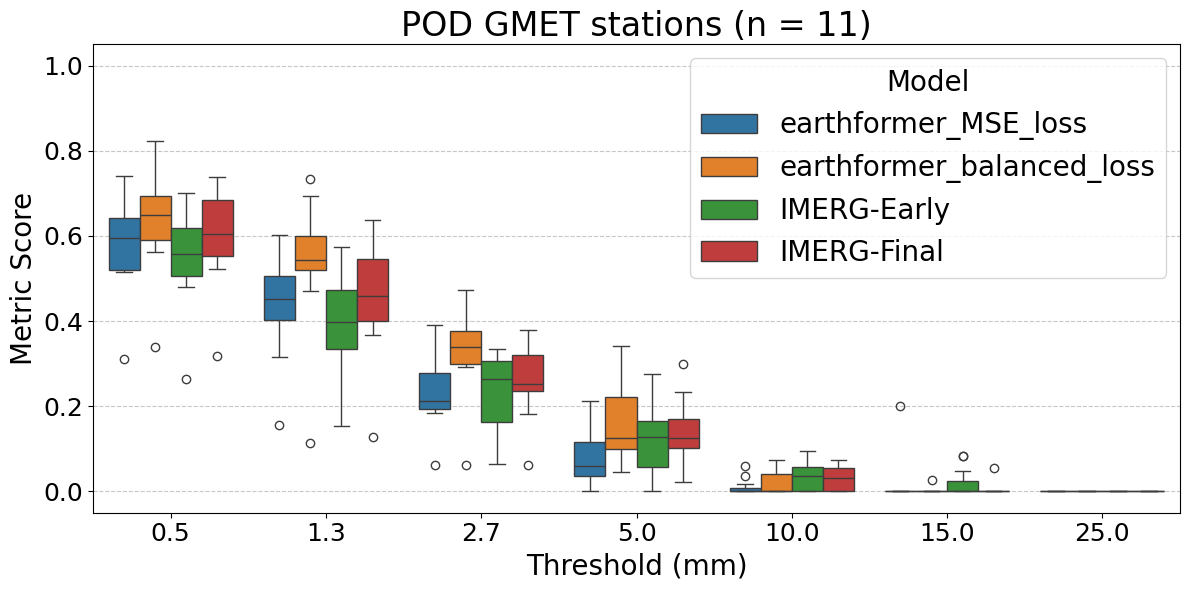

In [14]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="POD", hue="model", dodge = True, data=df_combined_gmet)

# Add plot labels and title
plt.title(f"POD GMET stations (n = {df_combined_gmet['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('POD_GMET_30min.png')
plt.show()

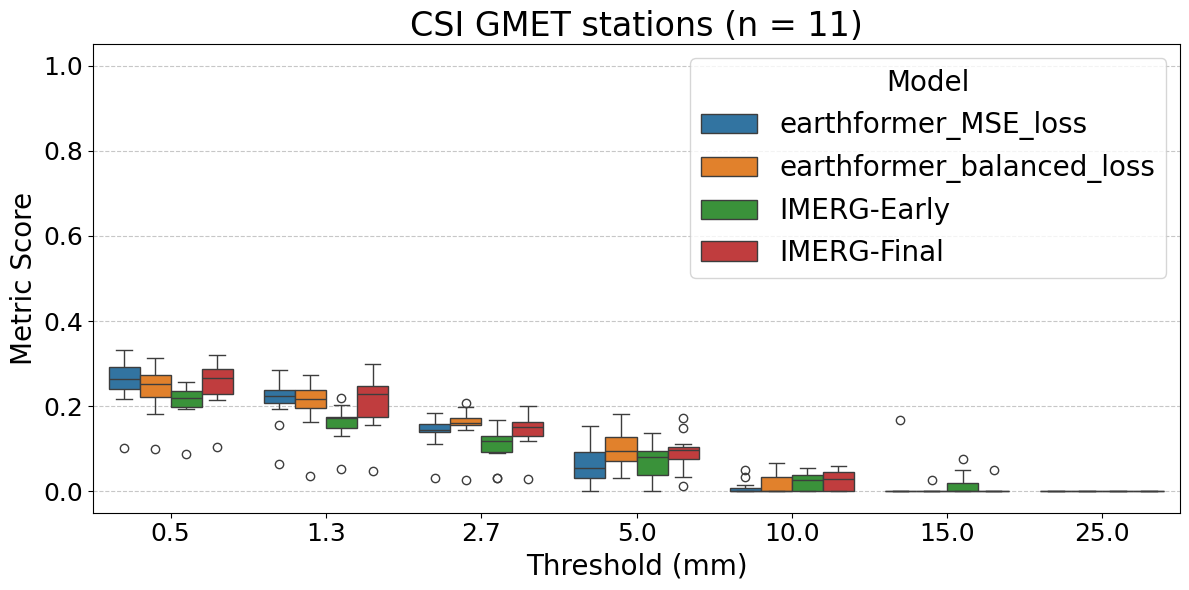

In [15]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="CSI", hue="model", dodge = True, data=df_combined_gmet)

# Add plot labels and title
plt.title(f"CSI GMET stations (n = {df_combined_gmet['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)


# Show the plot
plt.tight_layout()

plt.savefig('CSI_GMET_30min.png')
plt.show()

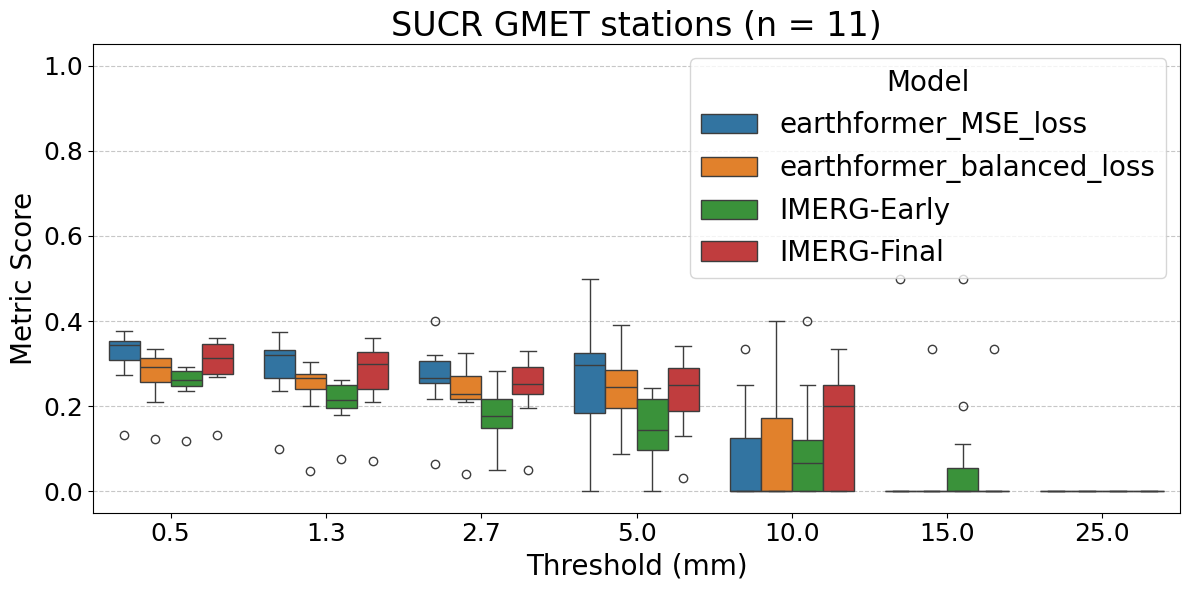

In [16]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="SUCR", hue="model", dodge = True, data=df_combined_gmet)

# Add plot labels and title
plt.title(f"SUCR GMET stations (n = {df_combined_gmet['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('SUCR_GMET_30min.png')
plt.show()

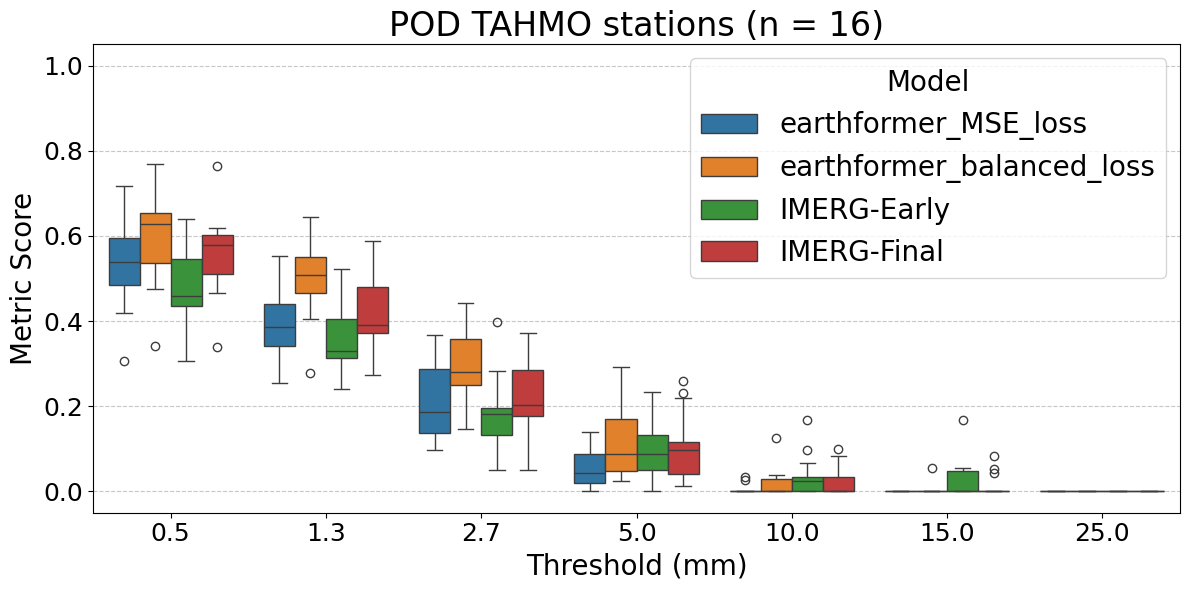

In [17]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="POD", hue="model", dodge = True, data=df_combined_tahmo)

# Add plot labels and title
plt.title(f"POD TAHMO stations (n = {df_combined_tahmo['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('POD_TAHMO_30min.png')
plt.show()

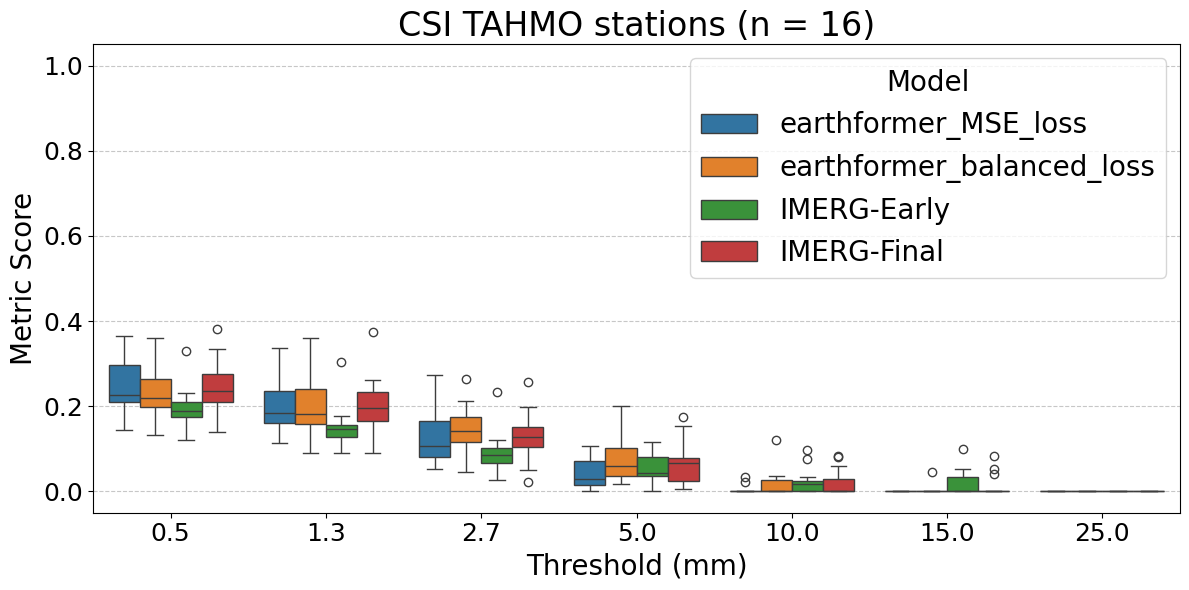

In [18]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="CSI", hue="model", dodge = True, data=df_combined_tahmo)

# Add plot labels and title
plt.title(f"CSI TAHMO stations (n = {df_combined_tahmo['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('CSI_TAHMO_30min.png')
plt.show()

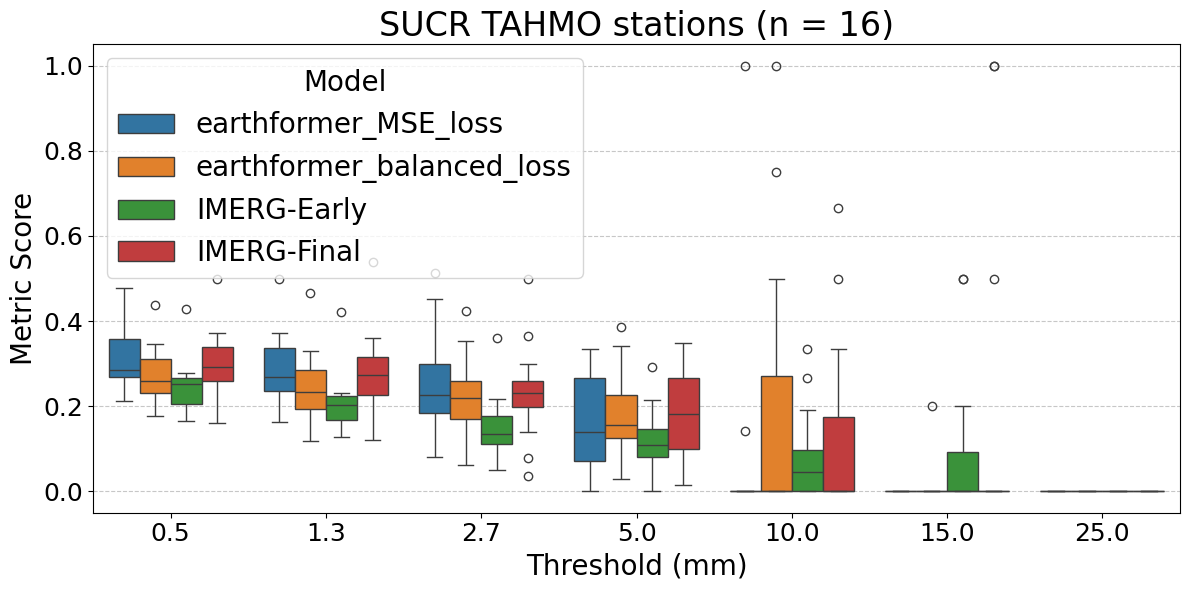

In [19]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="SUCR", hue="model", dodge = True, data=df_combined_tahmo)

# Add plot labels and title
plt.title(f"SUCR TAHMO stations (n = {df_combined_tahmo['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()
plt.savefig('SUCR_TAHMO_30min.png')
plt.show()

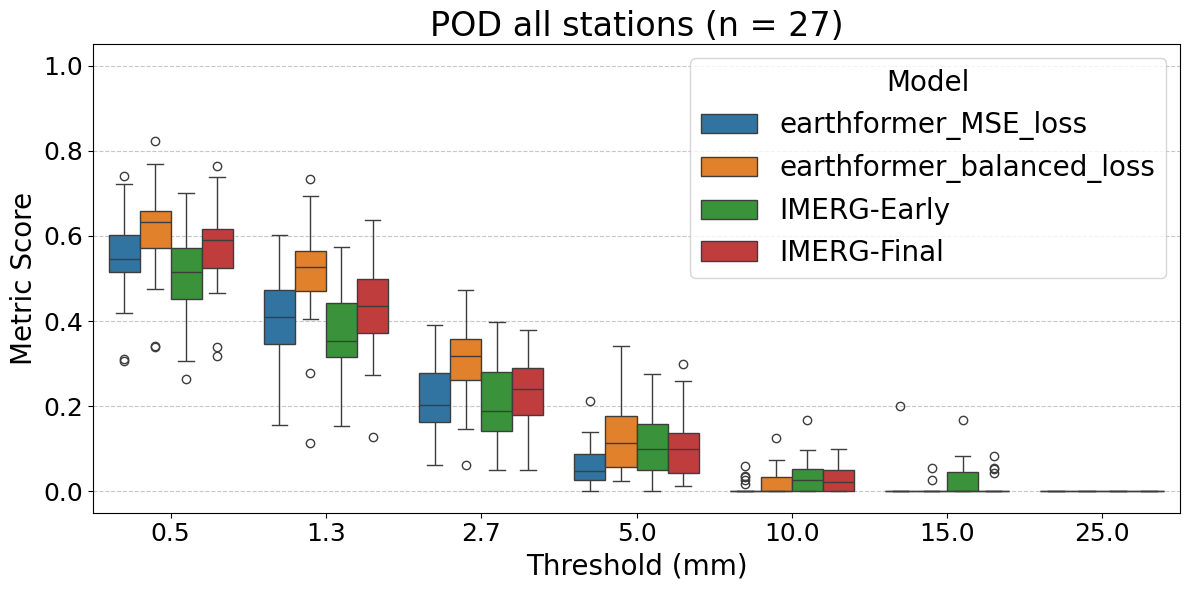

In [20]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="POD", hue="model", dodge = True, data=df_combined_total)

# Add plot labels and title
plt.title(f"POD all stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()
plt.savefig('POD_all_30min.png')
plt.show()

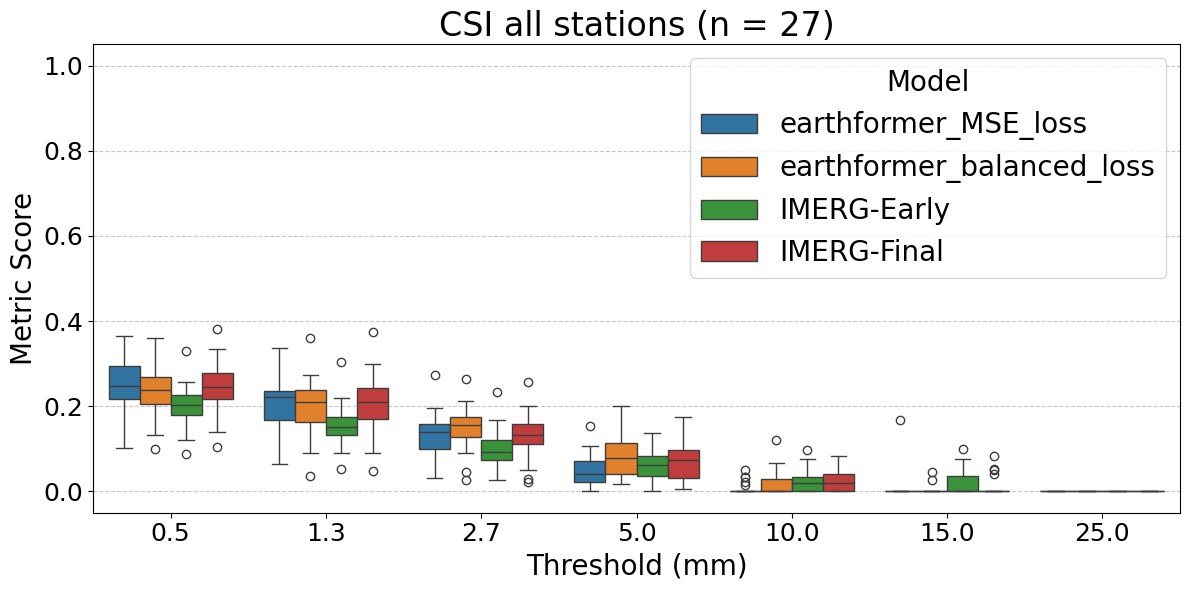

In [21]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="CSI", hue="model", dodge = True, data=df_combined_total)

# Add plot labels and title
plt.title(f"CSI all stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('CSI_all_30min.png')

plt.show()

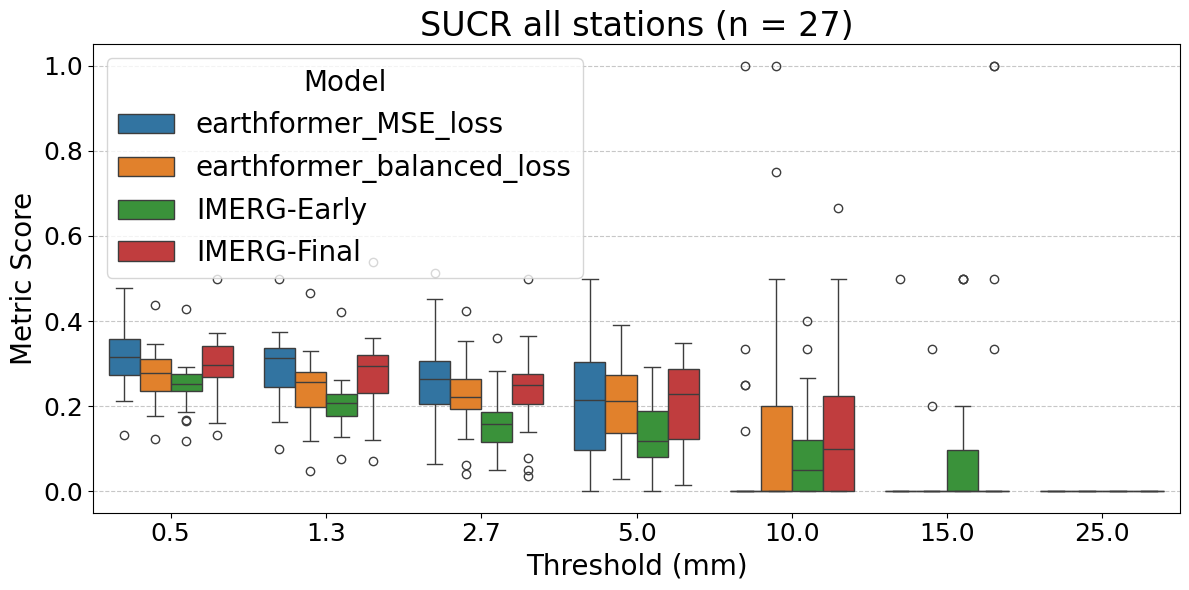

In [22]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="SUCR", hue="model", dodge = True, data=df_combined_total)

# Add plot labels and title
plt.title(f"SUCR all stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 1.05)

# Show the plot
plt.tight_layout()

plt.savefig('SUCR_all_30min.png')
plt.show()

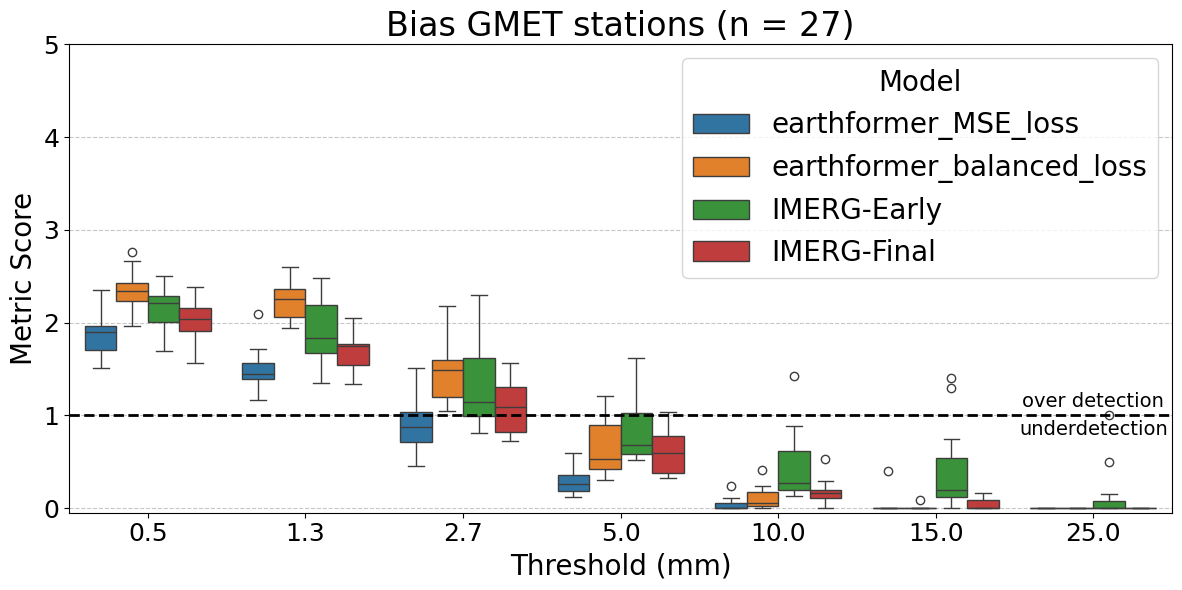

In [23]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="Bias", hue="model", dodge = True, data=df_combined_gmet)

# Add plot labels and title
plt.title(f"Bias GMET stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 5)
plt.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Determine the center of the x-axis for annotation placement
xmin, xmax = plt.xlim()
x_center =  xmax - 0.5 #(xmin + xmax) / 2

# Annotate above the horizontal line for "over detection"
plt.text(x_center, 1 + 0.05, 'over detection',
         ha='center', va='bottom', fontsize=14, color='black')

# Annotate below the horizontal line for "underdetection"
plt.text(x_center, 1 - 0.05, 'underdetection',
         ha='center', va='top', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

plt.savefig('Bias_gmet_30min.png')
plt.show()

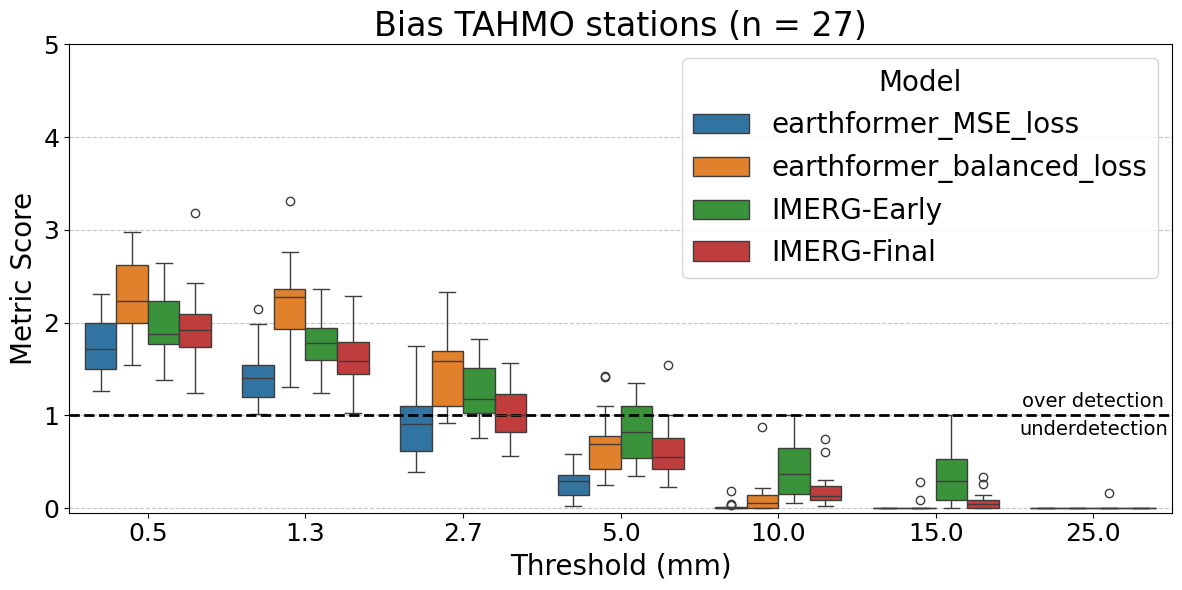

In [24]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="Bias", hue="model", dodge = True, data=df_combined_tahmo)

# Add plot labels and title
plt.title(f"Bias TAHMO stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 5)
plt.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Determine the center of the x-axis for annotation placement
xmin, xmax = plt.xlim()
x_center =  xmax - 0.5 #(xmin + xmax) / 2

# Annotate above the horizontal line for "over detection"
plt.text(x_center, 1 + 0.05, 'over detection',
         ha='center', va='bottom', fontsize=14, color='black')

# Annotate below the horizontal line for "underdetection"
plt.text(x_center, 1 - 0.05, 'underdetection',
         ha='center', va='top', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

plt.savefig('Bias_tahmo_30min.png')
plt.show()

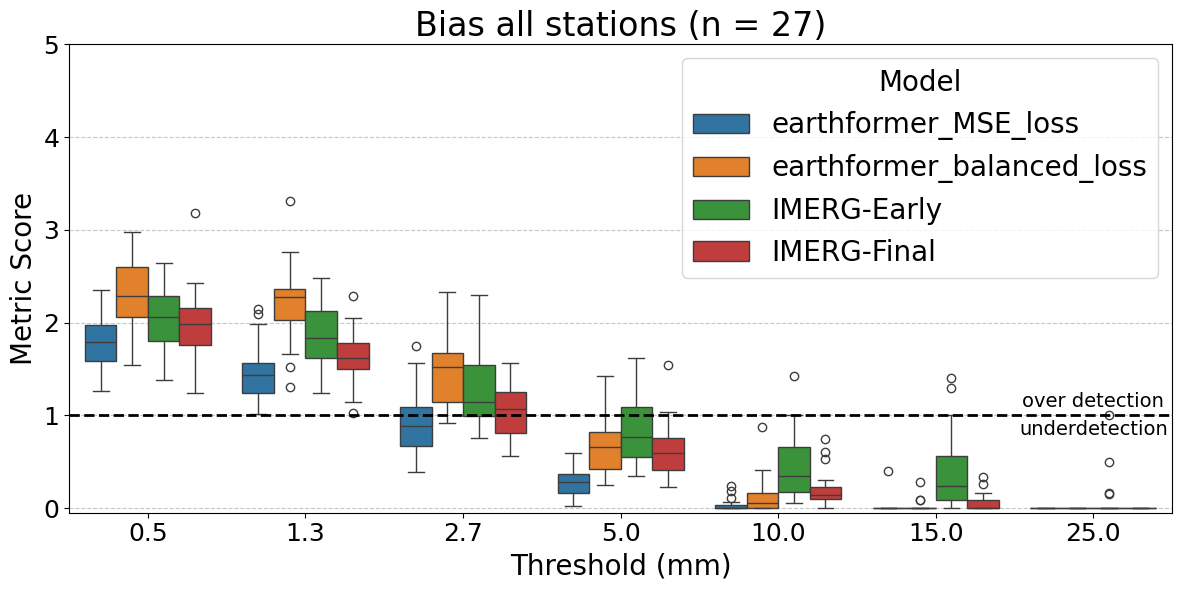

In [25]:
# Create a grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Threshold", y="Bias", hue="model", dodge = True, data=df_combined_total)

# Add plot labels and title
plt.title(f"Bias all stations (n = {df_combined_total['Station'].nunique()})", fontsize=24)
plt.xlabel("Threshold (mm)", fontsize=20)
plt.ylabel("Metric Score", fontsize=20)
plt.legend(title="Model", fontsize = 20, title_fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-0.05, 5)
plt.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Determine the center of the x-axis for annotation placement
xmin, xmax = plt.xlim()
x_center =  xmax - 0.5 #(xmin + xmax) / 2

# Annotate above the horizontal line for "over detection"
plt.text(x_center, 1 + 0.05, 'over detection',
         ha='center', va='bottom', fontsize=14, color='black')

# Annotate below the horizontal line for "underdetection"
plt.text(x_center, 1 - 0.05, 'underdetection',
         ha='center', va='top', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

plt.savefig('Bias_all_30min.png')
plt.show()